In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
seed = 0

In [2]:
class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for agents.
    """

    def __init__(self, obs_dim, size):
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size
        self.seed = np.random.RandomState(seed)

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = self.seed.randint(0, self.size, size=batch_size)
        batch = dict(obs=torch.as_tensor(self.obs_buf[idxs], dtype=torch.float32),
                     obs2=torch.as_tensor(self.obs2_buf[idxs], dtype=torch.float32),
                     act=torch.as_tensor(self.act_buf[idxs], dtype=torch.int64),
                     rew=torch.as_tensor(self.rew_buf[idxs], dtype=torch.float32),
                     done=torch.as_tensor(self.done_buf[idxs], dtype=torch.float32))
        return batch

In [3]:
class Network(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Network, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
        )

    def forward(self, x):
        return self.layers(x)

In [4]:
class DQNAgent:
    def __init__(
        self,
        env,
        memory_size,
        batch_size,
        target_update,
        epsilon_decay,
        start_size=500,
        max_epsilon=1.0,
        min_epsilon=0.01,
        gamma=0.99,
    ):
        self.env = env
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.target_update = target_update
        self.epsilon_decay = epsilon_decay
        self.start_size = start_size
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.gamma = gamma

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        self.memory = ReplayBuffer(obs_dim, memory_size)
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        self.optimizer = torch.optim.Adam(self.dqn.parameters())
        
        self.epsilon = max_epsilon

    def select_action(self, state):
        if self.epsilon > np.random.random():
            selected_action = env.action_space.sample()
        else:
            selected_action = self.dqn(torch.tensor(state, dtype=torch.float32).to(self.device)).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        return selected_action

    def train(self, num_frames, output_interval=1000):
        self.dqn.train()
        state = self.env.reset()
        scores = []
        score = 0
        update_cnt = 0
        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done, _ = self.env.step(action)
            self.memory.store(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                state = self.env.reset()
                scores.append(score)
                score = 0
                # Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials.
                if len(scores) >= 100 and np.mean(scores[-100:]) >= 195:
                    print("solved in {} trials".format(len(scores) - 100))
                    break
            if self.memory.size >= self.start_size:
                update_cnt += 1
                samples = self.memory.sample_batch()
                loss = self._compute_dqn_loss(samples)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                if update_cnt % self.target_update == 0:
                    self.dqn_target.load_state_dict(self.dqn.state_dict())
            if frame_idx % output_interval == 0:
                print(frame_idx, scores[-1], np.mean(scores[-100:]))
        return scores

    def _compute_dqn_loss(self, samples):
        state = samples["obs"].to(self.device)
        next_state = samples["obs2"].to(self.device)
        action = samples["act"].reshape(-1, 1).to(self.device)
        reward = samples["rew"].reshape(-1, 1).to(self.device)
        done = samples["done"].reshape(-1, 1).to(self.device)
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).gather(
            1, self.dqn(next_state).argmax(dim=1, keepdim=True)
        ).detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)
        loss = nn.MSELoss()(curr_q_value, target)
        return loss

In [5]:
env = gym.make("CartPole-v0")
num_frames = 100000
memory_size = 1000
batch_size = 32
target_update = 50
epsilon_decay = 1 / 5000

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
env.seed(seed)
env.action_space.np_random.seed(seed)

agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay)

cuda


In [6]:
scores = agent.train(num_frames)

1000 14.0 22.386363636363637
2000 26.0 27.356164383561644
3000 63.0 34.28735632183908
4000 200.0 41.42391304347826
5000 200.0 49.50515463917526
6000 176.0 59.26
7000 200.0 68.07
8000 200.0 76.88
9000 164.0 84.99
10000 104.0 93.68
11000 137.0 102.66
12000 200.0 111.22
13000 200.0 119.51
14000 200.0 128.15
15000 149.0 137.75
16000 156.0 144.75
17000 200.0 153.08
18000 200.0 161.37
19000 200.0 168.9
20000 128.0 177.12
21000 200.0 182.72
22000 200.0 187.45
23000 143.0 187.55
24000 200.0 187.3
25000 200.0 187.84
26000 200.0 188.1
27000 200.0 188.1
28000 200.0 188.81
29000 200.0 190.64
30000 200.0 191.58
31000 200.0 193.52
32000 200.0 194.23
33000 200.0 194.83
34000 200.0 194.83
solved in 152 trials


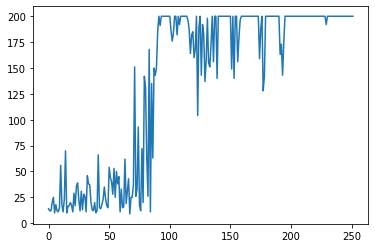

In [7]:
plt.figure()
plt.plot(np.arange(len(scores)), scores)
plt.show()